In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm.notebook import trange, tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img,
    show_array_of_images,
    show_function
)

from Feature_Extraction import (
    calculate_local_features
)

from Laplacian import Laplacian

from Global import calc_scales

In [2]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

In [3]:
train_images = colour_images[:-1]
train_labels = depth_images[:-1]
test_image = colour_images[-1]
test_labels = depth_images[-1]

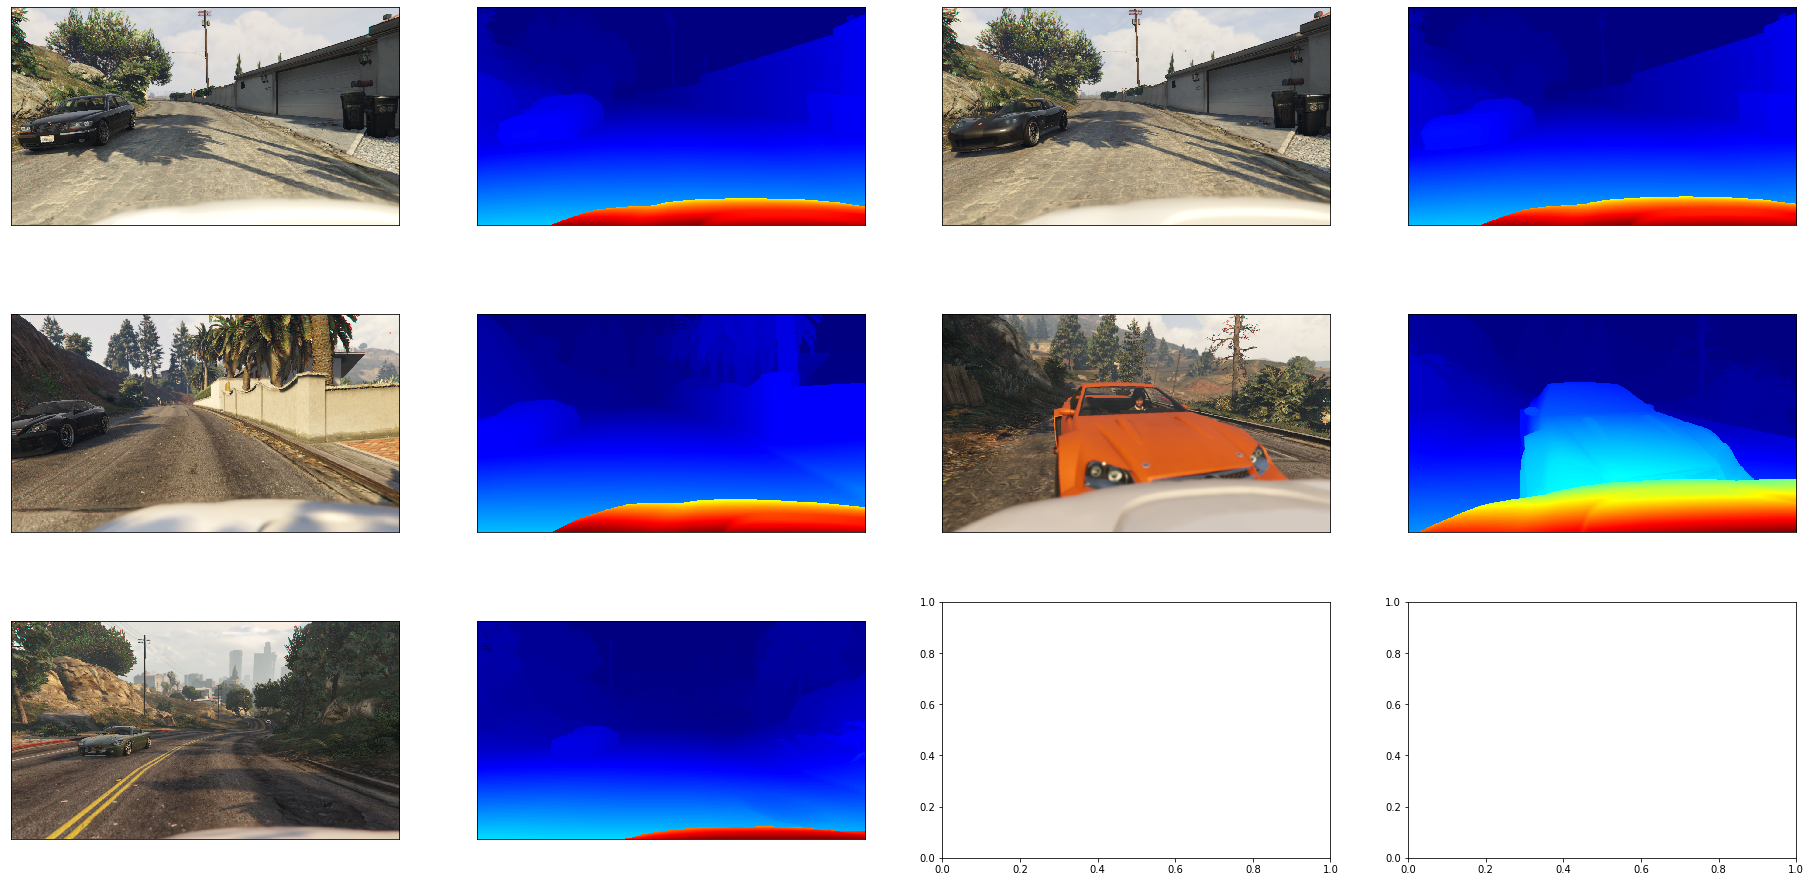

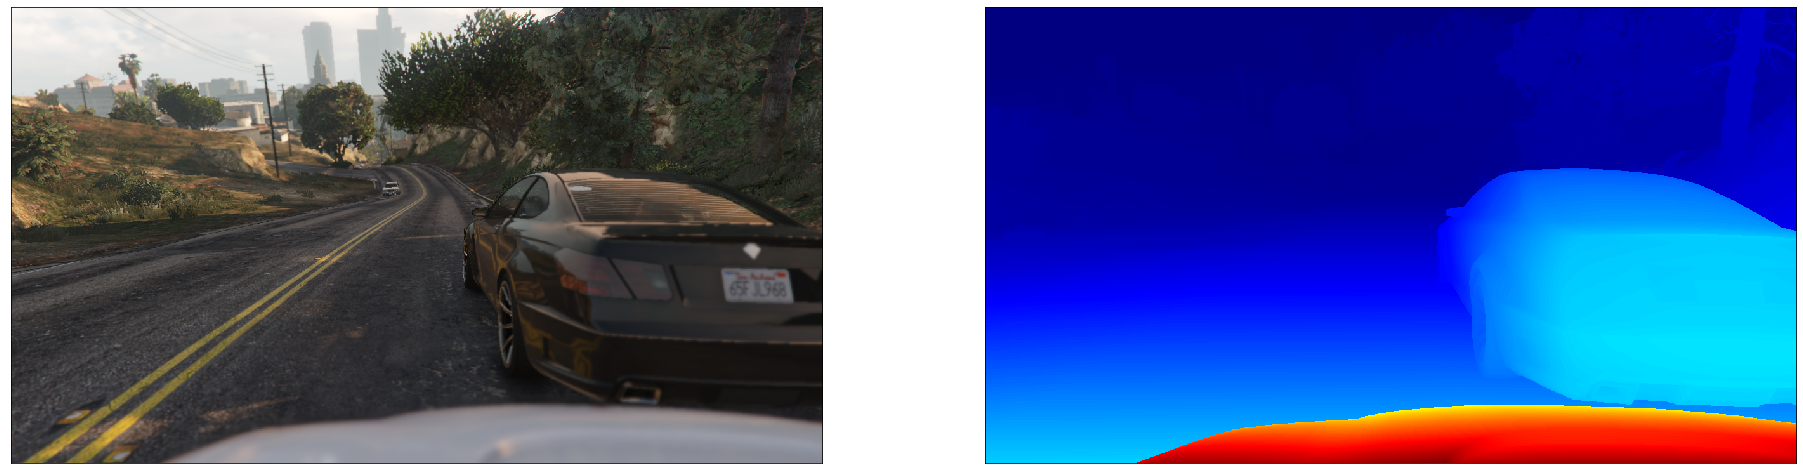

In [4]:
show_array_of_images([x for y in zip(train_images, train_labels) for x in y], image_array_shape=(3,4), depthmap=True)
show_array_of_images([test_image, test_labels], image_array_shape=(1,2), depthmap=True)

# Local

## Linear

In [27]:
initial_linear_weights = [np.full((1,40,34),1e-4)]

In [28]:
local_linear = Laplacian(initial_linear_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=True), neighbours=False)

In [29]:
# %debug
local_linear.train(train_images, train_labels, prep=None)

In [30]:
len(local_linear.weights)
local_linear.weights[0].shape

len(local_linear.initial_weights)
local_linear.initial_weights[0].shape

1

(1, 40, 34)

1

(1, 40, 34)

In [31]:
local_linear_prediction = local_linear.predict(test_image, neighbours=False, function=local_linear.linear_function)

In [32]:
local_linear_prediction.shape

(720, 1280)

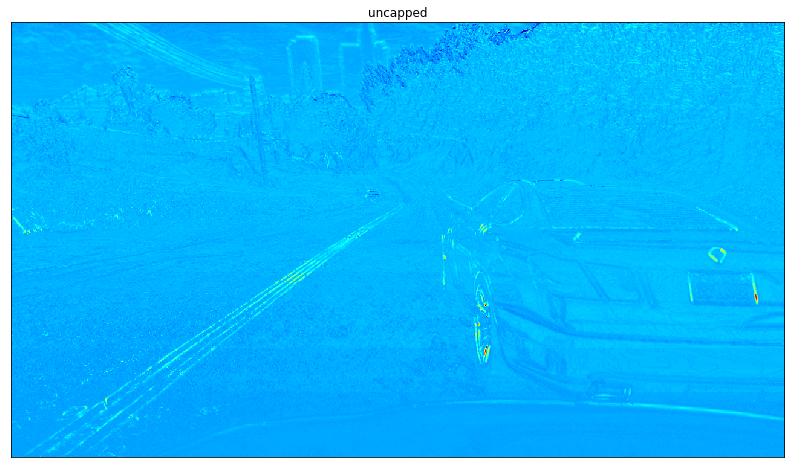

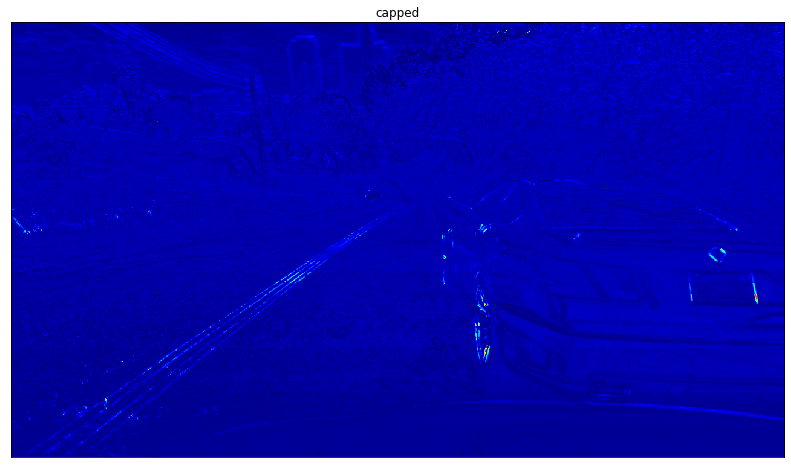

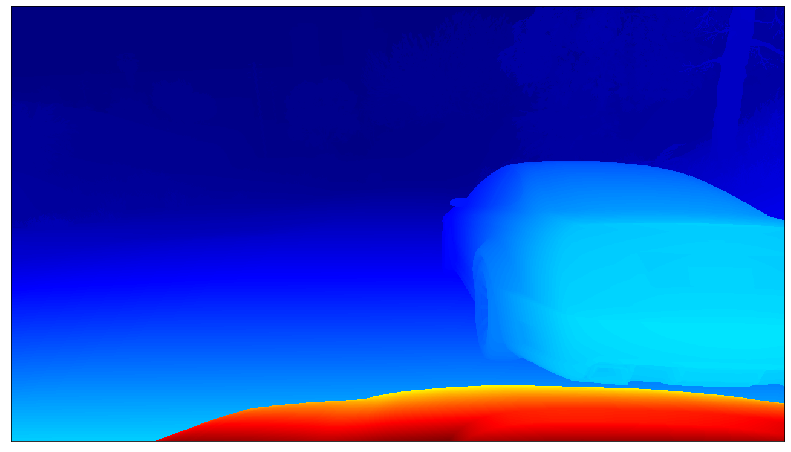

In [33]:
show_img(local_linear_prediction, depthmap=True, title='uncapped')
local_linear_prediction[local_linear_prediction>1]=1
show_img(local_linear_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [34]:
np.sum(np.sqrt((local_linear_prediction - test_labels)**2))

681558.7449145614

## Exponential

In [21]:
initial_exponential_weights = np.full((1,40, 17), 1e-5)

In [22]:
local_exponential = Laplacian(initial_exponential_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False)

In [23]:
local_exponential.train(train_images, train_labels, prep=np.log)

In [24]:
local_exponential_prediction = local_exponential.predict(test_image)

In [25]:
local_exponential_prediction.shape

(720, 1280)

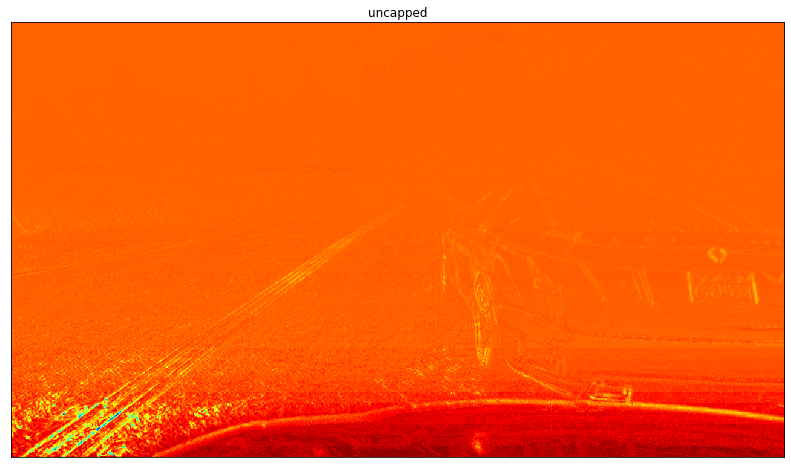

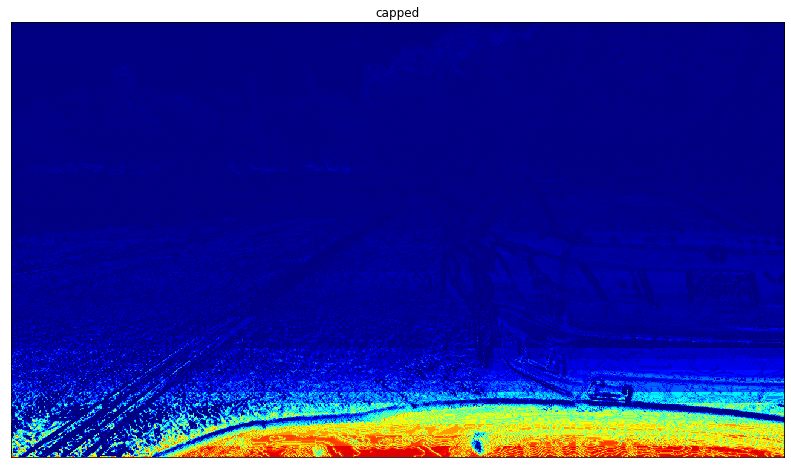

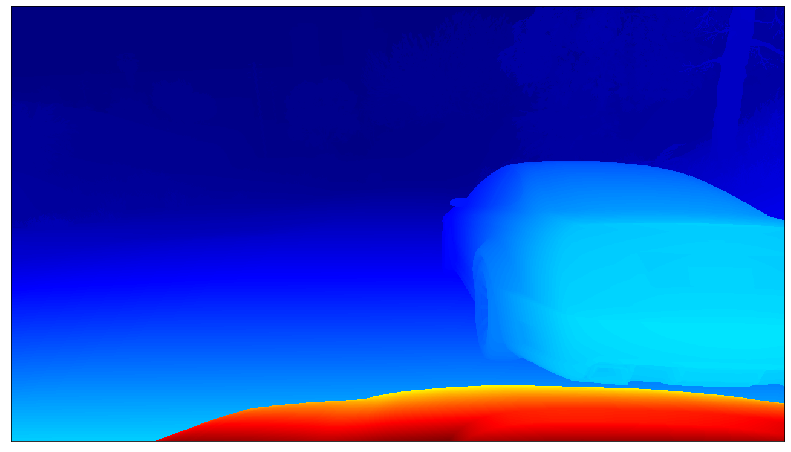

In [26]:
show_img(local_exponential_prediction, depthmap=True, title='uncapped')
local_exponential_prediction[local_exponential_prediction>1]=1
show_img(local_exponential_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [27]:
local_exponential_prediction

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99995717, 1.        ,
        1.        ],
       ...,
       [0.91959567, 0.89361327, 0.89469298, ..., 0.91652121, 0.89475235,
        0.89210194],
       [0.9327219 , 0.88944863, 0.88814521, ..., 0.88301108, 0.88119537,
        0.88119537],
       [0.90031227, 0.88544918, 0.87974056, ..., 0.87200401, 0.87335777,
        0.87335777]])

In [28]:
np.sum(np.sqrt((local_exponential_prediction - test_labels)**2))

13342.833656898196

# Whole Image

In [117]:
whole_image_weights = np.full((1,17), 1e-4)

In [118]:
whole_image = Laplacian(whole_image_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False)

In [119]:
whole_image.train(train_images, train_labels, prep=np.log)

In [120]:
whole_image_prediction = whole_image.predict(test_image)

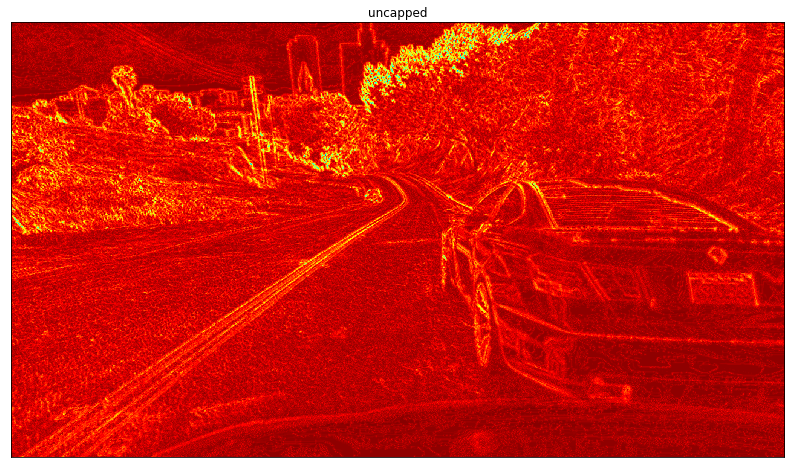

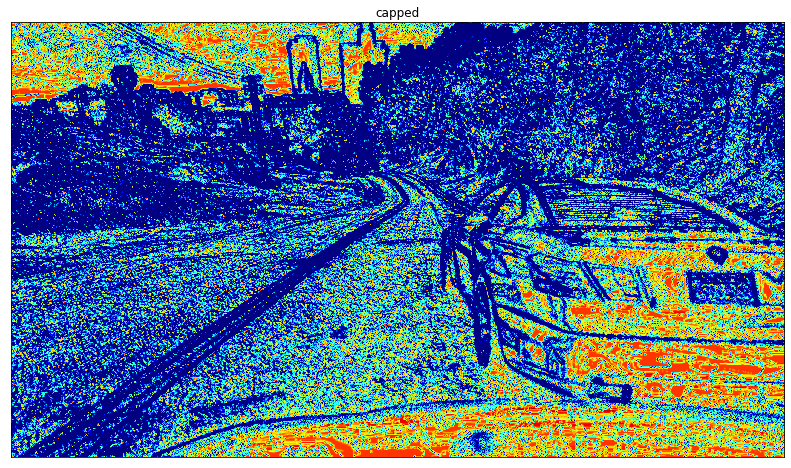

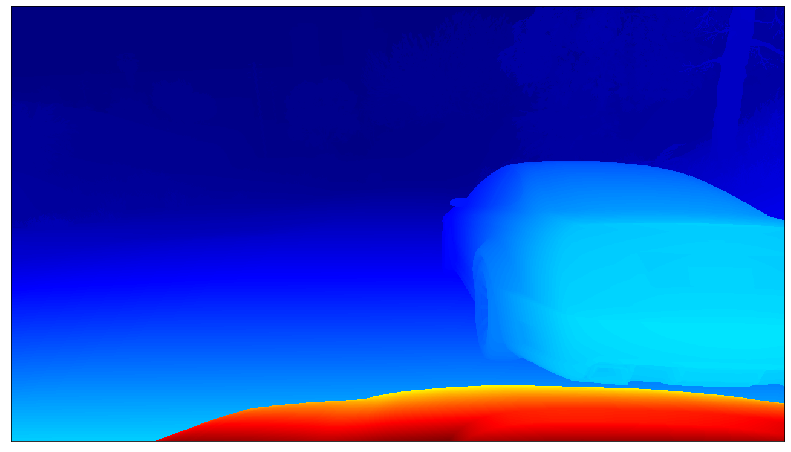

In [121]:
show_img(whole_image_prediction, depthmap=True, title='uncapped')
whole_image_prediction[whole_image_prediction>1]=1
show_img(whole_image_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

# With Neighbours


In [41]:
initial_neighbour_weights = np.full((1,40, 5*17), 1e-5)

In [42]:
neighbours = Laplacian(initial_neighbour_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=True)

In [45]:
neighbours.train(train_images, train_labels, prep=np.log)

In [47]:
neighbour_prediction = neighbours.predict(test_image)

In [48]:
neighbour_prediction.shape

(720, 1280)

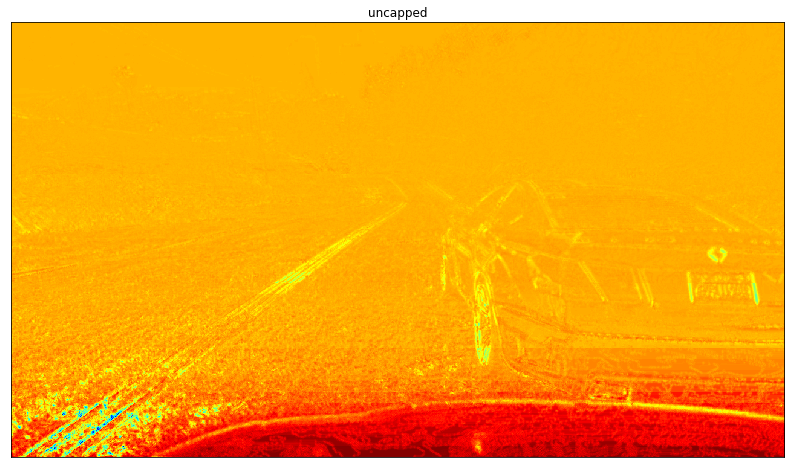

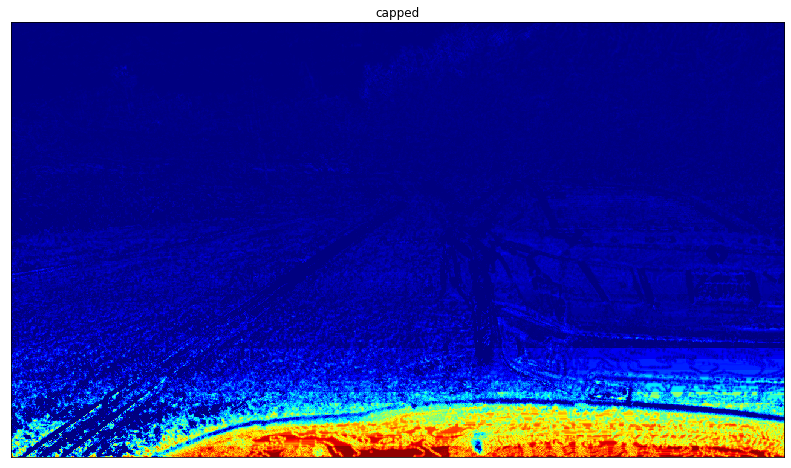

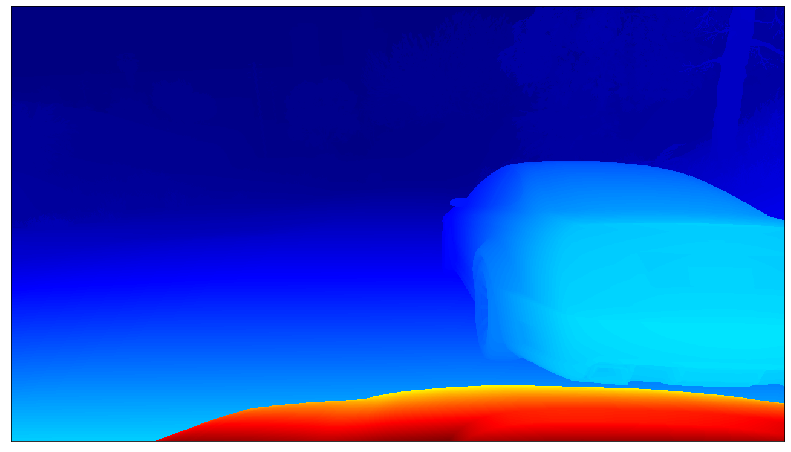

In [49]:
show_img(neighbour_prediction, depthmap=True, title='uncapped')
neighbour_prediction[neighbour_prediction>1]=1
show_img(neighbour_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [50]:
neighbour_prediction

array([[1.        , 1.        , 1.        , ..., 1.        , 0.99977295,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.9998867 , 0.99995813,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.92010574, 0.91520511, 0.90449227, ..., 0.89573912, 0.89203711,
        0.88742873],
       [0.92686022, 0.91193037, 0.90077737, ..., 0.89090301, 0.88243001,
        0.87869902],
       [0.92209311, 0.88580603, 0.87917326, ..., 0.87977676, 0.87401293,
        0.87483335]])

In [51]:
np.sum(np.sqrt((neighbour_prediction - test_labels)**2))

12432.050586346753

# Global

## Without Neighbours

In [197]:
initial_global_weights = [np.full((3,40,17), 1e-4)]
initial_combined_weights = np.full((40,3),1e-4)

In [198]:
global_exponential = Laplacian(initial_global_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False, relative_scales=[(1,1),(3,3),(3,3)], initial_combined_weights=initial_combined_weights)

In [199]:
# %debug
global_exponential.train(train_images, train_labels, prep=np.log)

> /storage/depth_estimation/Markov_Random_Field/Laplacian.py(65)train()
     63                 # predicted_images[predicted_images>1]=1
     64                 # Tracer()()
---> 65                 combined_weights = least_squares(least_squares_function, self.initial_combined_weights, predicted_images, labels)
     66 
     67                 if self.training_count == 0:

ipdb> exit


In [200]:
global_exponential_prediction = global_exponential.predict(test_image)

In [201]:
global_exponential_prediction.shape

(720, 1280)

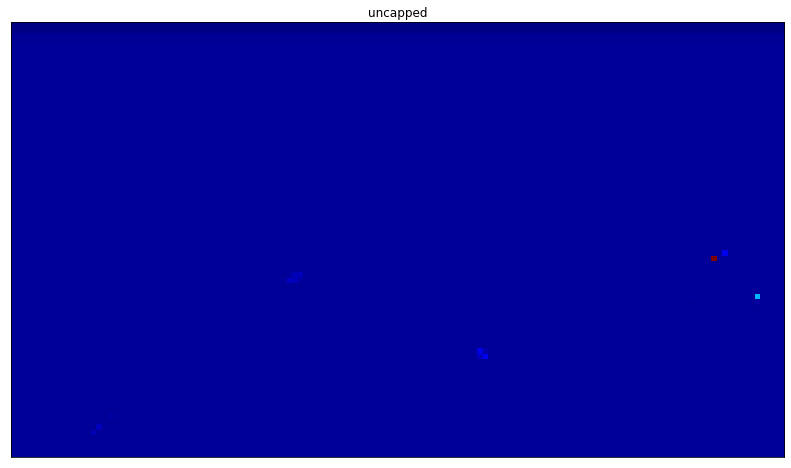

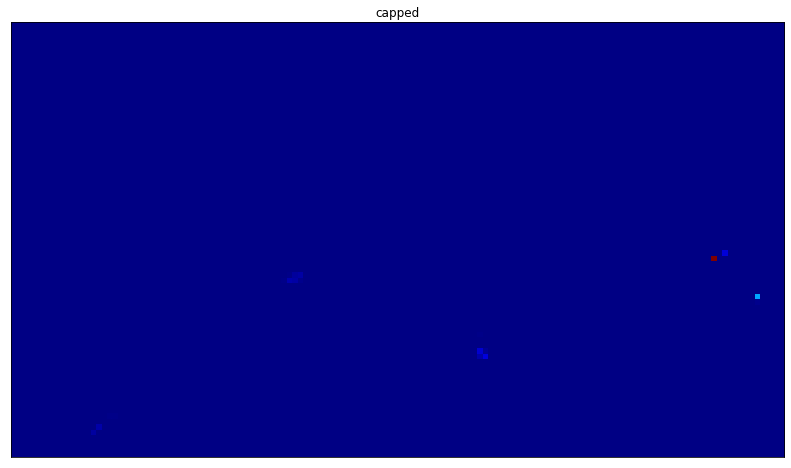

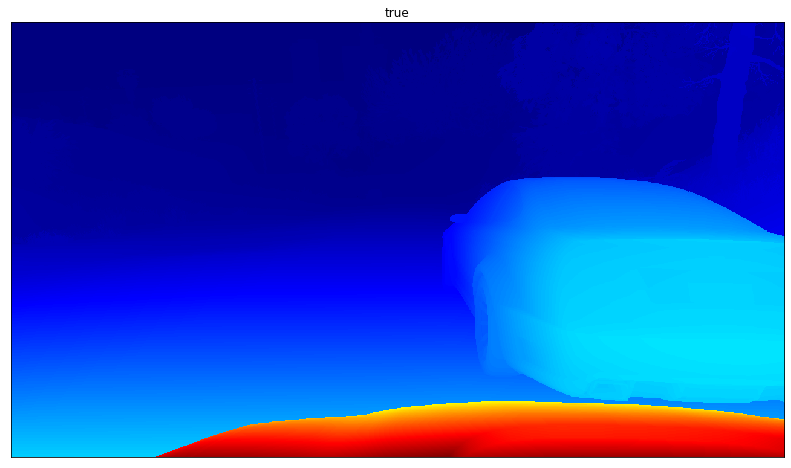

In [202]:
show_img(global_exponential_prediction, depthmap=True, title='uncapped')
global_exponential_prediction[global_exponential_prediction>1]=1
show_img(global_exponential_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True, title='true')

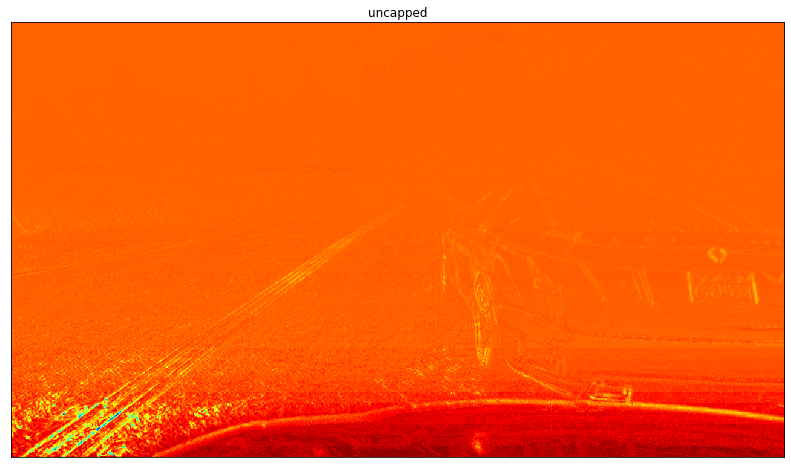

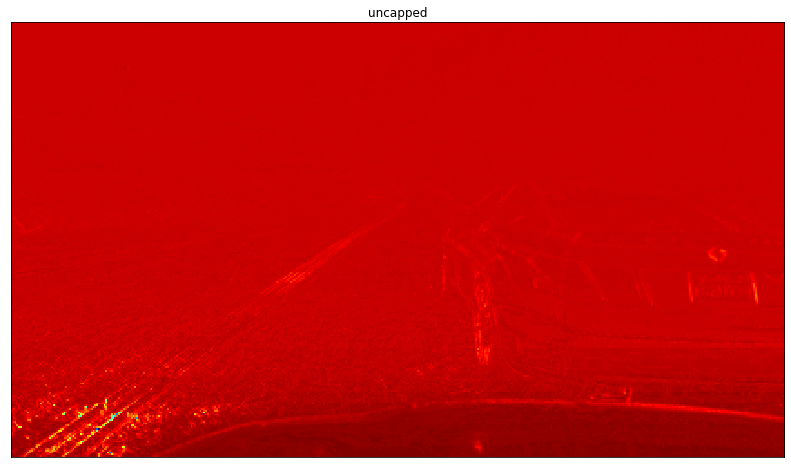

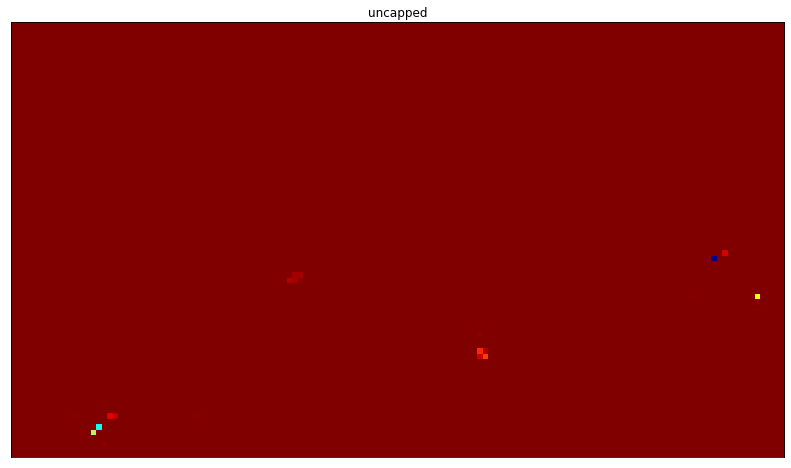

In [165]:
show_img(global_exponential_prediction[...,0], depthmap=True, title='uncapped')
show_img(global_exponential_prediction[...,1], depthmap=True, title='uncapped')
show_img(global_exponential_prediction[...,2], depthmap=True, title='uncapped')

In [154]:
global_exponential_prediction

array([[ 0.00465754,  0.00465754,  0.00465754, ...,  0.00453063,
         0.00452766,  0.00452679],
       [ 0.00466041,  0.00466041,  0.00466041, ...,  0.00452925,
         0.00452734,  0.00452564],
       [ 0.00465971,  0.00465971,  0.00465971, ...,  0.00453316,
         0.00452776,  0.00452433],
       ...,
       [-0.00758302, -0.00734451, -0.00735442, ..., -0.00762794,
        -0.0075487 , -0.00752437],
       [-0.00770352, -0.00730627, -0.00729431, ..., -0.00732032,
        -0.00742424, -0.00742424],
       [-0.007406  , -0.00726956, -0.00721715, ..., -0.00721928,
        -0.00735229, -0.00735229]])

In [28]:
np.sum(np.sqrt((local_exponential_prediction - test_labels)**2))

13342.833656898196